# Software Pricing

Data Challenge: 2020 July 9 \
Candidate: Isaac Chung\
Time alloted: 3 hours\
Task: To evaluate whether a pricing test running on the site has been successful. Focus here is on user segmentation and provide insights about who behave differently.

## 0. Import data
First let's import the data set, and see what's inside. Data is given in a csv file. Let's use pandas' read_csv function, using the user_id column as index.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.stats import shapiro
from scipy.stats import skew
from scipy.stats import kurtosis

In [2]:
results = pd.read_csv('test_results.csv', header=0, index_col=1)
users = pd.read_csv('user_table.csv', header=0, index_col=0)

## 1. Initial Data Analysis:
1. Data set shape, types
2. NaN values
3. Duplicates

### 1.1 Shape and types
results has 316800 rows and 8 features, and users has 275616 rows and 4 features. \
There are some floats, ints, and some objects. 

In [3]:
print(results.shape)
print(results.info())
print(users.shape)
print(users.info())

(316800, 8)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 316800 entries, 604839 to 832372
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        316800 non-null  int64  
 1   timestamp         316466 non-null  object 
 2   source            316488 non-null  object 
 3   device            316800 non-null  object 
 4   operative_system  296461 non-null  object 
 5   test              316800 non-null  int64  
 6   price             316800 non-null  float64
 7   converted         316800 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 21.8+ MB
None
(275616, 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 275616 entries, 510335 to 232078
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   city     275616 non-null  object 
 1   country  275616 non-null  object 
 2   lat      275616 non-null  float64
 3 

In [4]:
results.head()

,Unnamed: 0,timestamp,source,device,operative_system,test,price,converted
user_id,,,,,,,,
604839,0,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0
624057,1,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0
317970,2,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0
685636,3,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0
820854,4,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0


Reading the unique labels of selected columns and see if they make sense. Do some cleaning if needed.

In [5]:
results['operative_system'].unique()

array(['iOS', 'android', 'mac', 'windows', nan, 'i0S', 'wnddows',
       'anroid', 'apple'], dtype=object)

In [6]:
results = results.fillna('Other')

In [7]:
results = results.replace({'wnddows': 'windows',
                           'anroid': 'android',
                           'i0S': 'iOS',
                           'apple': 'Other'})

In [8]:
results = results.drop('Unnamed: 0', axis=1)

In [9]:
results['device'].unique()

array(['mobile', 'web'], dtype=object)

In [10]:
results['source'].unique()

array(['ads_facebook', 'seo-google', 'ads-bing', 'direct_traffic',
       'ads-google', 'seo_facebook', 'friend_referral', 'ads_other',
       'ads-yahoo', 'seo-yahoo', 'seo-bing', 'seo-other', 'Other'],
      dtype=object)

In [11]:
source_cats = ['ads','seo']
results['source_cats'] = np.where(results['source'].str.contains('ads'),'ads',np.where(results['source'].str.contains('seo'),'seo',results['source']))

In [12]:
results.head()

,timestamp,source,device,operative_system,test,price,converted,source_cats
user_id,,,,,,,,
604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0,ads
624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0,seo
317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0,ads
685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0,direct_traffic
820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0,ads


In [13]:
users.head()

,city,country,lat,long
user_id,,,,
510335,Peabody,USA,42.53,-70.97
89568,Reno,USA,39.54,-119.82
434134,Rialto,USA,34.11,-117.39
289769,Carson City,USA,39.15,-119.74
939586,Chicago,USA,41.84,-87.68


### 1.2 NaN values
There is no missing data in users but some missing data in results. Since the amount only accounts for about 6% of the total data, it's acceptable to drop these from the analysis.

In [14]:
results.isna().sum()

timestamp           0
source              0
device              0
operative_system    0
test                0
price               0
converted           0
source_cats         0
dtype: int64

In [15]:
users.isna().sum()

city       0
country    0
lat        0
long       0
dtype: int64

### 1.3 Duplicates
We also check for duplicated rows. Users and results do not have duplicate indices.

In [16]:
users.index.duplicated().sum()

0

In [17]:
results.index.duplicated().sum()

0

### 1.4 Join the tables on user_id

In [18]:
data = results.join(users)

In [19]:
data.head()

,timestamp,source,device,operative_system,test,price,converted,source_cats,city,country,lat,long
user_id,,,,,,,,,,,,
604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0,ads,Buffalo,USA,42.89,-78.86
624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0,seo,Lakeville,USA,44.68,-93.24
317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0,ads,Parma,USA,41.38,-81.73
685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0,direct_traffic,Fayetteville,USA,35.07,-78.90
820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0,ads,Fishers,USA,39.95,-86.02


### 1.5 Cleaning
Let's see which columns we can use.

In [20]:
data['country'].unique()

array(['USA', nan], dtype=object)

The number of rows with country == 'USA' equals the total number of rows in the dataframe. Let's drop the country column.

In [21]:
data[data['country']=='USA']

,timestamp,source,device,operative_system,test,price,converted,source_cats,city,country,lat,long
user_id,,,,,,,,,,,,
604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0,ads,Buffalo,USA,42.89,-78.86
624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0,seo,Lakeville,USA,44.68,-93.24
317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0,ads,Parma,USA,41.38,-81.73
685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0,direct_traffic,Fayetteville,USA,35.07,-78.90
820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0,ads,Fishers,USA,39.95,-86.02
...,...,...,...,...,...,...,...,...,...,...,...,...
388438,2015-05-20 11:34:44,seo-google,web,windows,1,59.0,0,seo,Joliet,USA,41.53,-88.12
687787,2015-03-16 23:31:55,direct_traffic,web,windows,0,39.0,0,direct_traffic,Bell Gardens,USA,33.97,-118.15
618863,2015-04-11 01:35:19,ads-google,web,mac,0,39.0,0,ads,West Seneca,USA,42.84,-78.75


In [22]:
data = data.drop('country', axis=1)

In [23]:
data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316800 entries, 604839 to 832372
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   timestamp         305905 non-null  datetime64[ns]
 1   source            316800 non-null  object        
 2   device            316800 non-null  object        
 3   operative_system  316800 non-null  object        
 4   test              316800 non-null  int64         
 5   price             316800 non-null  float64       
 6   converted         316800 non-null  int64         
 7   source_cats       316800 non-null  object        
 8   city              275616 non-null  object        
 9   lat               275616 non-null  float64       
 10  long              275616 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(5)
memory usage: 39.0+ MB


In [24]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266116 entries, 604839 to 832372
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   timestamp         266116 non-null  datetime64[ns]
 1   source            266116 non-null  object        
 2   device            266116 non-null  object        
 3   operative_system  266116 non-null  object        
 4   test              266116 non-null  int64         
 5   price             266116 non-null  float64       
 6   converted         266116 non-null  int64         
 7   source_cats       266116 non-null  object        
 8   city              266116 non-null  object        
 9   lat               266116 non-null  float64       
 10  long              266116 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(5)
memory usage: 24.4+ MB


### 1.6 Data quality
Let's check for unreasonable data. This category includes users that are assigned to the test group but shown with a price of 39, and not assigned to the test group but shown with a price of 59.

In [25]:
print((data[data.test == 1]['price'] == 39).sum())
print((data[data.test == 0]['price'] == 59).sum())

130
180


Let's drop these incorrect rows from our data. We now have 263227 entries.

In [26]:
data = data[((data.test == 1) & (data.price == 59)) | ((data.test == 0) & (data.price == 39))]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263227 entries, 604839 to 832372
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   timestamp         263227 non-null  datetime64[ns]
 1   source            263227 non-null  object        
 2   device            263227 non-null  object        
 3   operative_system  263227 non-null  object        
 4   test              263227 non-null  int64         
 5   price             263227 non-null  float64       
 6   converted         263227 non-null  int64         
 7   source_cats       263227 non-null  object        
 8   city              263227 non-null  object        
 9   lat               263227 non-null  float64       
 10  long              263227 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(5)
memory usage: 24.1+ MB


## 2. Exploratory Data Analysis

Next, let's visualize the distributions of the features.

direct_traffic     50155
ads-google         49242
ads_facebook       44264
ads_other          24939
seo-google         19256
ads-bing           18999
seo_facebook       17532
friend_referral    17190
seo-other           7698
ads-yahoo           6226
seo-yahoo           5691
seo-bing            1775
Other                260
Name: source, dtype: int64


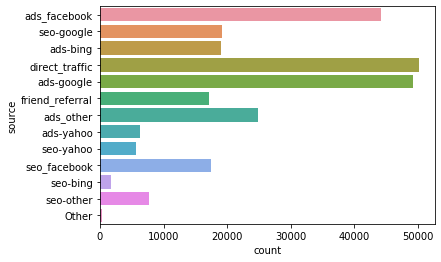

In [27]:
print(data.source.value_counts())
sns.countplot(y=data.source)

Zooming out from the sources, we see that ads are generating a lot of traffic compared to seo and direct traffic / friend referral.

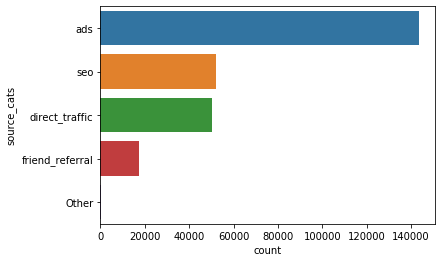

In [28]:
sns.countplot(y=data.source_cats)

When we look at the OS, we can perhaps group some of 'iOS', 'mac', and 'apple' users. Note that doing so makes Apple users count higher than windows users count.

windows    83767
iOS        79326
android    62266
mac        20890
Other      16978
Name: operative_system, dtype: int64


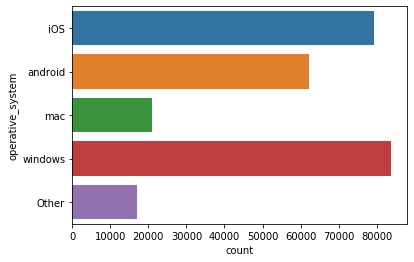

In [29]:
print(data.operative_system.value_counts())
sns.countplot(y=data.operative_system)

About 30% difference between mobile user and web users.

mobile    154976
web       108251
Name: device, dtype: int64


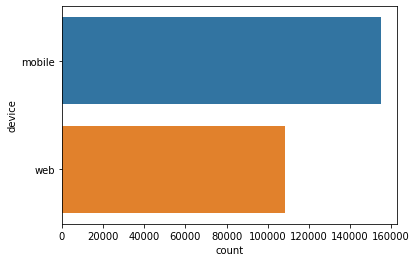

In [30]:
print(data.device.value_counts())
sns.countplot(y=data.device)

Users come from 900+ different cities in the United States. It would be more sensible to group them by region. This can potentially be done with the lat/lon coordinates. Maybe for when there's more time.

In [31]:
print(data.city.value_counts())

New York       24624
Chicago         6805
Houston         6398
San Antonio     4421
Los Angeles     3976
               ...  
Costa Mesa         1
New Milford        1
East Lake          1
Tustin             1
Ocala              1
Name: city, Length: 923, dtype: int64


Let's look at the test and converted columns.

0    168469
1     94758
Name: test, dtype: int64


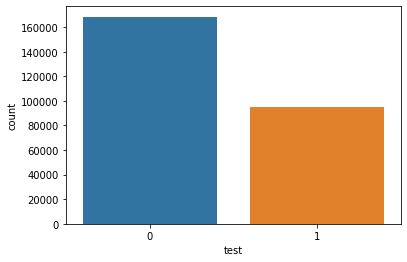

In [32]:
print(data.test.value_counts())
sns.countplot(data.test)

0    258431
1      4796
Name: converted, dtype: int64


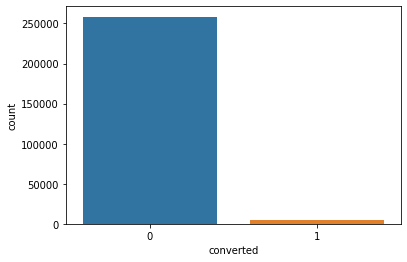

In [33]:
print(data.converted.value_counts())
sns.countplot(data.converted)

Let's look at the conversion rates for each price point.

In [34]:
print('{:.3f}% conversion rate for $59.'.format(((data.converted == 1) & (data.price == 59)).sum() / (data.price == 59).sum() * 100))
print('{:.3f}% conversion rate for $39.'.format(((data.converted == 1) & (data.price == 39)).sum() / (data.price == 39).sum() *100))

1.542% conversion rate for $59.
1.980% conversion rate for $39.


## 3. A/B Testing

We only use the data from columns test and converted. We can perform hypothesis testing to determine whether the differences between the two samples are statistically significant or not. 

Null hypothesis: The proportion of users in test group that are converted is same as the user in control group.\
Alternative hypothesis: The proportion of users in test group that are converted is lower compared to the user in control group.

Since we are dealing with mostly categorical data, we can use a chi-squared test. 

In [35]:
# we can split the groups into two dataframes: low price, high price
low = data[data['price'] == 39]
high = data[data['price'] == 59]

In [36]:
# we want the converted values of each dataframe
low_con = low.converted.sum()
low_nocon = low.converted.size - low_con
high_con = high.converted.sum()
high_nocon = high.converted.size - high_con

We use the scipy library's built in function to calculate both the chi-squared statistic and the p-value. Here we see the p-value is much less than 5%, we can deduce that the p-value is less than the assumed 'alpha', and we reject the null hypothesis. That is, there is statistical significance in conversions between the low price and the high price.

In [37]:
from scipy import stats

T = np.array([[low_con, low_nocon], [high_con, high_nocon]])
print('p-value is {:.3e}'.format(stats.chi2_contingency(T, correction=False)[1]))

p-value is 7.592e-16


### 3.1 Should the company sell its software for the original price or the new price?

We are interested in the revenue of the company. So our efforts should be directed towards finding out if the increased price would maintain the same revenue or not (increase/decrease). 

In [38]:
data['revenue'] = data['price'] * data['converted']

Revenue per visitor is higher at 59USD than at 39USD. The company should sell its software at the higher (new) price.

In [39]:
data.groupby('test')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
test,,,,,,,,
0,168469.0,0.772041,5.432654,0.0,0.0,0.0,0.0,39.0
1,94758.0,0.909675,7.269380,0.0,0.0,0.0,0.0,59.0


### 3.2 Has the test been running for too long?

In order to determine the minimum sample size required for running a statistically robust test, we can plug these numbers into an [A/B test calculator](https://www.abtasty.com/sample-size-calculator/). To detect a relative 22% change in conversion rate for a baseline conversion rate of 1.98% at 95% confidence level and 80% power, a sample size of 16,564 is needed.

Looking at the differences in the max timestamp and the min timestamp, we can see that the test has been running for almost 91 days. 

In [40]:
print(max(data.timestamp))
print(min(data.timestamp))
print(max(data.timestamp)-min(data.timestamp))

2015-05-31 23:59:45
2015-03-02 00:04:12
90 days 23:55:33


In [41]:
avg_visitors = data.count()/91
print(avg_visitors)

timestamp           2892.604396
source              2892.604396
device              2892.604396
operative_system    2892.604396
test                2892.604396
price               2892.604396
converted           2892.604396
source_cats         2892.604396
city                2892.604396
lat                 2892.604396
long                2892.604396
revenue             2892.604396
dtype: float64


Here we can get average traffic per day, which is 2893 daily visitors. The same calculator tells us that the required duration for the A/B test is 11 days. So the test has been running for too long.

In [42]:
dates = data.set_index('timestamp')

In [43]:
dates.head()

,source,device,operative_system,test,price,converted,source_cats,city,lat,long,revenue
timestamp,,,,,,,,,,,
2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0,ads,Buffalo,42.89,-78.86,0.0
2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0,seo,Lakeville,44.68,-93.24,0.0
2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0,ads,Parma,41.38,-81.73,0.0
2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0,direct_traffic,Fayetteville,35.07,-78.90,0.0
2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0,ads,Fishers,39.95,-86.02,0.0


In [44]:
test_group = dates[dates['test']==1]
control_group = dates[dates['test']==0]

In [45]:
yt = test_group['converted'].resample('D').sum()
yc = control_group['converted'].resample('D').sum()

In [46]:
print(yt.mean())
print(yc.mean())

16.054945054945055
36.64835164835165


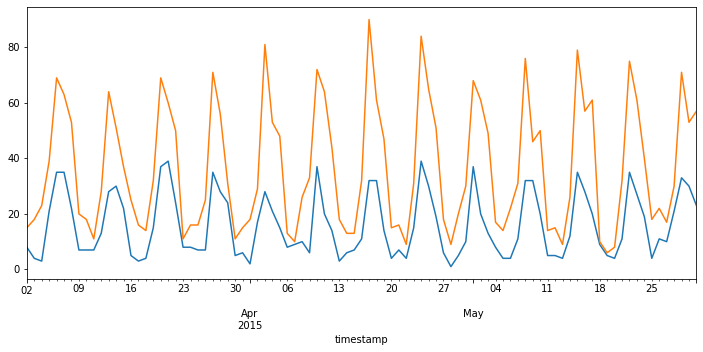

In [47]:
yt.plot(figsize=(12,5))
yc.plot()
plt.show()

### 3.3 Actionable insights and customer segmentation

In [48]:
def segmentation(df, col_name, rot=0):
    control = df[df['test']==0].groupby(col_name)
    test = df[df['test']==1].groupby(col_name)
    
    control_list = list()
    test_list = list()
    item_list = list()
    for item in df[col_name].unique():
        if type(item) != str:
            continue
        if item == "Other" and col_name == 'source':
            continue
        item_list.append(item)
        control_list.append(100*control['converted'].value_counts()[item,1]/control['converted'].agg('count')[item])
        test_list.append(100*test['converted'].value_counts()[item,1]/test['converted'].agg('count')[item])
        
    plotdf = pd.DataFrame({'control': control_list, 'test': test_list}, index=item_list)
    plotdf = plotdf.sort_values(by='control', ascending=False)
    ax = plotdf.plot.bar(rot=rot)
    plt.xlabel(col_name)
    plt.ylabel('Conversion %')
    

#### 3.3.1 By device
It might seem that there is some dependence on the device in the test group, but the same conversion rates in the control group makes me suspect that it is not statistically significant.

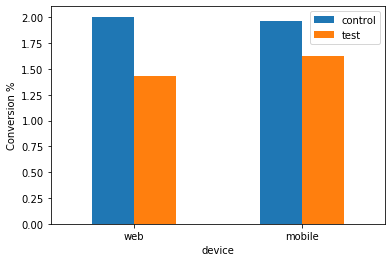

In [49]:
segmentation(data, 'device')

#### 3.3.2 By operating system
The conversion rates for iOS and mac users are higher than that of windows and android users. 

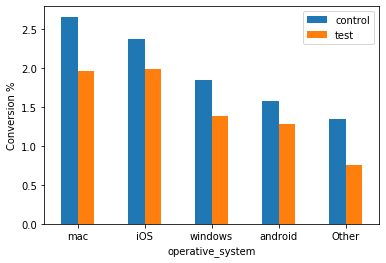

In [50]:
segmentation(data, 'operative_system')

#### 3.3.3 By sources
Friend referrals has the highest conversion rates for both the control and test groups.

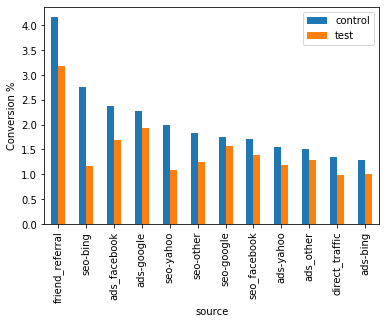

In [51]:
segmentation(data, 'source', rot=90)